# Exploring Dandiset 000563: Allen Institute Openscope - Barcoding

*A practical introduction for researchers interested in mouse visual system neural recordings from the DANDI Archive.*

---

**Notebook generated with the assistance of AI.**

Please use caution and verify all code, results, and interpretations—this notebook is intended as an exploratory starting point.

## Overview

This notebook provides an introduction to **Dandiset 000563: Allen Institute Openscope - Barcoding** ([DANDI Archive link](https://dandiarchive.org/dandiset/000563/0.250311.2145)), which contains large-scale Neuropixels electrophysiological, behavioral, and stimulus data from mouse visual cortex and related areas. It is designed to help researchers:

- Explore the contents and structure of the Dandiset
- Load NWB files directly from the archive for interactive data analysis
- Visualize Local Field Potentials (LFP), spike-sorted units, and behavioral data
- Examine visual/optogenetic stimulus presentation timing

**What this notebook covers:**

1. Dandiset and NWB Asset overview  
2. Loading remote NWB files with the DANDI API and streaming them with RemFile  
3. Example visualizations:
    - LFP (Local Field Potential) segment
    - Raster plot of spike-sorted units
    - Pupil area from eye tracking over time
    - Stimulus presentation/raster plot
4. Guidance to help you extend the analyses for your own research

## Requirements

This notebook assumes you have the following packages installed:

- `dandi`
- `pynwb`
- `remfile`
- `h5py`
- `matplotlib`
- `numpy`
- `pandas`

The code cells below use only APIs and methods discussed directly in the chat above.

## 1. Exploring the Dandiset and NWB Assets

In [1]:
from dandi.dandiapi import DandiAPIClient

# Connect to the DANDI Archive and fetch the Dandiset
dandiset_id = "000563"
dandiset_version = "0.250311.2145"

client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List the first 10 NWB file paths
print("First 10 NWB files in the Dandiset:")
assets = dandiset.get_assets_by_glob("*.nwb")
asset_list = [a.path for a in assets]
for fn in asset_list[:10]:
    print("  ", fn)

First 10 NWB files in the Dandiset:
   sub-699241/sub-699241_ses-1318772854_probe-1_ecephys.nwb
   sub-699241/sub-699241_ses-1318772854_probe-3_ecephys.nwb
   sub-699241/sub-699241_ses-1318772854_probe-4_ecephys.nwb
   sub-699241/sub-699241_ses-1318772854_probe-0_ecephys.nwb
   sub-699241/sub-699241_ses-1318772854_ogen.nwb
   sub-699241/sub-699241_ses-1318772854_probe-2_ecephys.nwb
   sub-699846/sub-699846_ses-1314466742_probe-1_ecephys.nwb
   sub-699846/sub-699846_ses-1314466742_probe-2_ecephys.nwb
   sub-699846/sub-699846_ses-1314466742_probe-4_ecephys.nwb
   sub-699846/sub-699846_ses-1314466742_probe-3_ecephys.nwb


### Example File Structure

File names follow this general pattern:
- `sub-<subjectID>/sub-<subjectID>_ses-<session_id>_probe-<N>_ecephys.nwb` (electrophysiology: usually LFP & spikes)
- `sub-<subjectID>/sub-<subjectID>_ses-<session_id>_ogen.nwb` (optogenetics/behavior/stimulus/units/metadata aggregation)

Let's pick one file from each: an *ecephys* (LFP) file and the corresponding *ogen* (with spikes, opto, behavior, stimuli).

## 2. Loading NWB Data Remotely ("Streaming" from DANDI)

Files will be streamed using RemFile, which allows analysis without needing to download entire NWB files.

In [2]:
import h5py
import pynwb
import remfile

# Example NWB file: LFP data for one probe
lfp_asset_path = "sub-699241/sub-699241_ses-1318772854_probe-1_ecephys.nwb"
asset = next(dandiset.get_assets_by_glob(lfp_asset_path))
lfp_url = asset.download_url

# Example NWB file: "ogen" file for same session (spikes, behavior, opto, stimuli)
ogen_asset_path = "sub-699241/sub-699241_ses-1318772854_ogen.nwb"
asset_ogen = next(dandiset.get_assets_by_glob(ogen_asset_path))
ogen_url = asset_ogen.download_url

# (Files are not downloaded, but streamed as needed.)

## 3. LFP Data: Visualize a 10-Second Segment

Let's load and plot 10 seconds of LFP data from channel 0 in the LFP-only NWB file.

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


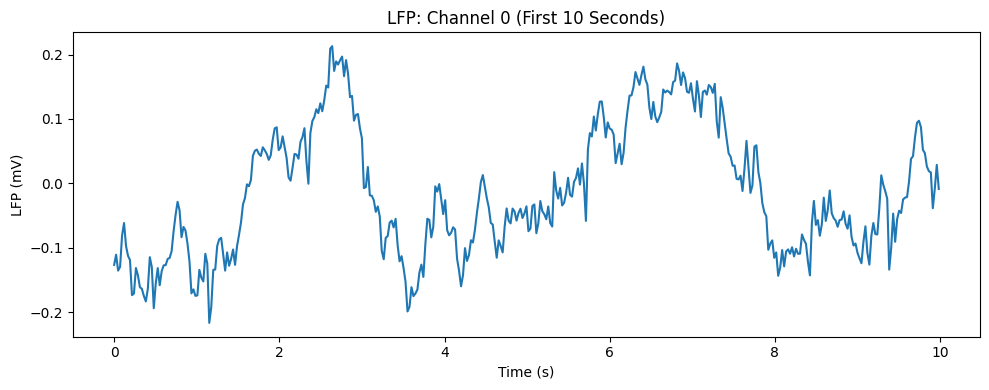

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Open the LFP file remotely
remote_file = remfile.File(lfp_url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Access LFP for probe 1 (shape: [samples, channels])
lfp = nwb.acquisition['probe_1_lfp'].electrical_series['probe_1_lfp_data']
lfp_timestamps = lfp.timestamps[:]  # In ms, from our exploration above
channel_idx = 0

# Select a segment for the first 10,000 ms = 10 s
mask = lfp_timestamps < 10000
seg_times = lfp_timestamps[mask] / 1000  # convert ms to s
seg_data = lfp.data[:len(seg_times), channel_idx]

# Plot the LFP segment
plt.figure(figsize=(10,4))
plt.plot(seg_times, seg_data * 1e3)
plt.xlabel('Time (s)')
plt.ylabel('LFP (mV)')
plt.title('LFP: Channel 0 (First 10 Seconds)')
plt.tight_layout()
plt.show()

## 4. Spike-Sorted Units: Raster Plot for 10 Units

The "ogen" NWB files contain spike-sorted units. We'll show a raster plot for the first 10 units in a 10-second window where spikes are present (20–30 s).

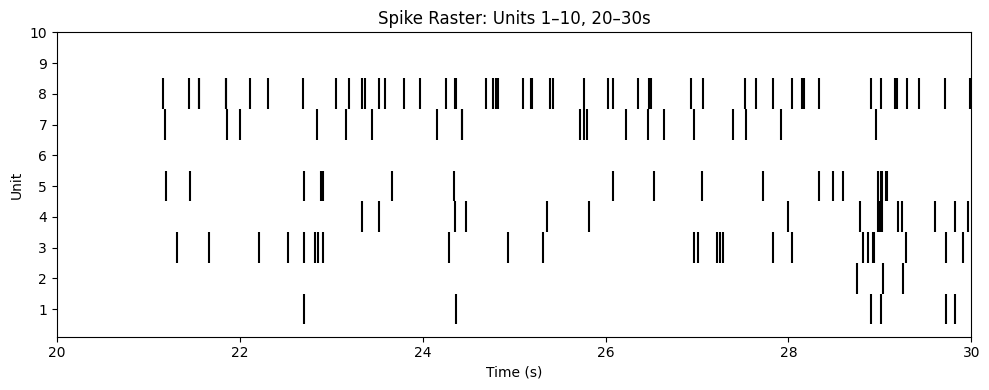

In [4]:
# Access the ogen NWB file remotely
remote_file_ogen = remfile.File(ogen_url)
h5_file_ogen = h5py.File(remote_file_ogen, 'r')
io_ogen = pynwb.NWBHDF5IO(file=h5_file_ogen, load_namespaces=True)
nwb_ogen = io_ogen.read()

# Correct way to get spike times: units.spike_times_index[i] gives array of spike times for unit i
num_units = 10
spike_times_list = [nwb_ogen.units.spike_times_index[i] for i in range(num_units)]

# Select a window (20–30 s) where spikes are present for these units
window_start, window_end = 20, 30
spikes_window = [st[(st >= window_start) & (st < window_end)] for st in spike_times_list]

plt.figure(figsize=(10,4))
for i, st in enumerate(spikes_window):
    plt.vlines(st, i + 0.5, i + 1.5, color='black')
plt.xlabel('Time (s)')
plt.ylabel('Unit')
plt.yticks(np.arange(1, num_units+1), np.arange(1, num_units+1))
plt.title('Spike Raster: Units 1–10, 20–30s')
plt.xlim(window_start, window_end)
plt.tight_layout()
plt.show()

## 5. Pupil Area (Eye Tracking) Over 30 Seconds

The ogen file contains rich behavioral data, including pupil tracking. Let's plot pupil area for the first 30 seconds of recording.

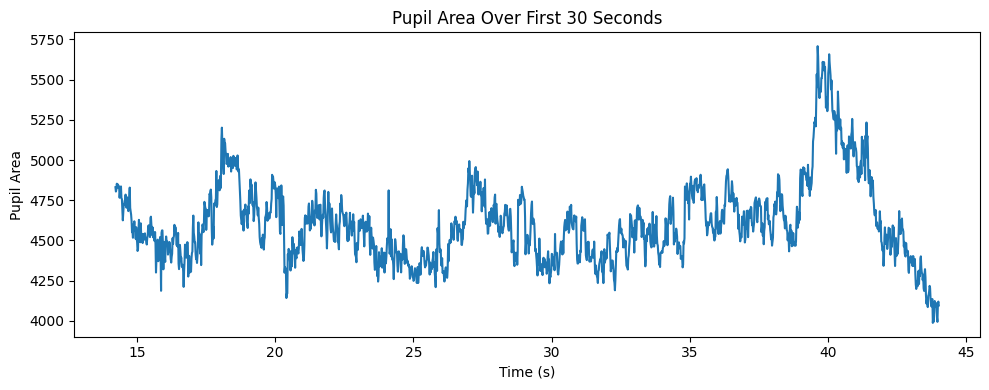

In [5]:
pupil = nwb_ogen.acquisition['EyeTracking'].spatial_series['pupil_tracking']
pupil_area = pupil.area[:]
pupil_timestamps = pupil.timestamps[:]
# The data may start later than t=0. We'll just use the first 30 seconds of available timestamps.
mask = (pupil_timestamps >= pupil_timestamps[0]) & (pupil_timestamps < pupil_timestamps[0] + 30)
plot_times = pupil_timestamps[mask]
plot_area = pupil_area[mask]

plt.figure(figsize=(10,4))
plt.plot(plot_times, plot_area)
plt.xlabel('Time (s)')
plt.ylabel('Pupil Area')
plt.title('Pupil Area Over First 30 Seconds')
plt.tight_layout()
plt.show()

## 6. Exploring Unit Properties

Spike-sorted units in the ogen file have many associated quality metrics. Here's a table and summary for some key unit properties.

In [6]:
import pandas as pd
units = nwb_ogen.units
to_show = ['firing_rate', 'quality', 'isolation_distance', 'snr', 'amplitude', 'waveform_duration']
avail = [c for c in units.colnames if c in to_show]
unit_df = units.to_dataframe()[avail]

# Show first 10 units and summary statistics
display(unit_df.head(10))
display(unit_df.describe(include='all').transpose())

,snr,quality,waveform_duration,amplitude,isolation_distance,firing_rate
id,,,,,,
15,4.266568,good,0.357119,79.209585,35.342475,0.603134
16,3.548613,good,0.370854,159.862170,42.580614,0.433529
17,2.785697,good,0.398325,111.336615,40.738294,1.387662
18,2.814532,good,0.315913,115.052340,41.385245,2.919751
19,2.896491,good,0.315913,113.427210,33.658400,2.812781
20,1.794729,good,0.315913,73.619910,68.527454,1.467367
21,2.855068,good,0.425796,117.041925,49.570874,3.282294
22,2.872371,good,0.425796,125.039655,81.055900,4.681623
23,3.965438,good,0.384590,163.542405,74.633663,2.644528


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
snr,2299.0,NaN,NaN,NaN,2.522401,1.224698,0.083774,1.7781,2.332249,3.050105,16.578439
quality,2299,2,good,1892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
waveform_duration,2299.0,NaN,NaN,NaN,0.561769,0.274314,0.027471,0.439531,0.549414,0.645561,2.692127
amplitude,2299.0,NaN,NaN,NaN,148.608092,106.531619,3.650595,85.60578,124.56288,177.547208,1194.582529
isolation_distance,2299.0,NaN,NaN,NaN,1187541212875.352051,28212101421380.742188,-1.0,39.566828,56.990347,81.070401,1264066678676772.5
firing_rate,2299.0,NaN,NaN,NaN,6.497488,7.584592,0.000246,1.052137,3.842923,9.485836,78.179053


## 7. Stimulus Presentation Times: Event Raster

Let's visualize when visual stimuli are presented, as captured in the stimulus processing module.

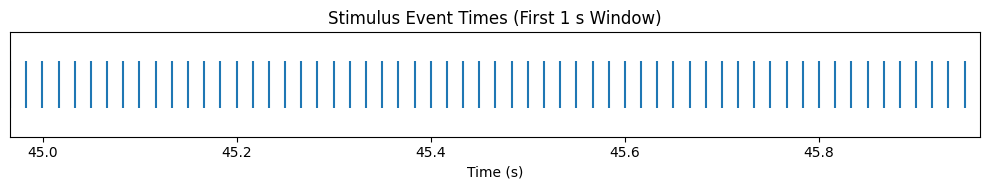

In [7]:
stimulus = nwb_ogen.processing['stimulus']
stim_timestamps = stimulus.data_interfaces['timestamps'].data[:]

# Select a 1-second window to see individual events
window_start = stim_timestamps[0]
window_end = window_start + 1
mask = (stim_timestamps >= window_start) & (stim_timestamps < window_end)
window_times = stim_timestamps[mask]

plt.figure(figsize=(10,2))
plt.eventplot(window_times, orientation='horizontal', colors='tab:blue', lineoffsets=0.5, linelengths=0.8)
plt.xlabel('Time (s)')
plt.yticks([])
plt.title('Stimulus Event Times (First 1 s Window)')
plt.xlim(window_start, window_end)
plt.tight_layout()
plt.show()

## Conclusion & Next Steps

This notebook offered initial exploratory analyses for Dandiset 000563:
- How to access and stream data files with the DANDI API, RemFile, and pynwb
- How to examine LFP, spikes, behavioral tracking, and visual stimulus structure

**You can now build on these examples to:**
- Overlay behavioral, neural, and stimulus data
- Quantify responses to specific events or stimuli
- Examine higher-dimensional aspects (across probes, units, sessions)

For further analyses, see also the interactive DANDI Archive and Neurosift NWB browser for this Dandiset.

---

*Notebook generated with the assistance of AI. Please check all analyses and code before using in your research.*